In [1]:
from scipy.special import lambertw
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def streaming_operator(f_inm, c_ai):

    '''streaming'''
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift=c_ai.T[i], axis=(0, 1))
    ''''''
    return f_inm

def feq(rho_nm, u_anm, c_ai, w_i):

    '''c * u'''
    cu_nm = np.einsum('ai,anm->inm', c_ai, u_anm)
    ''''''

    '''squaring cu'''
    sqcu_nm = cu_nm**2
    ''''''

    '''scalar product of the velocity vectors with itself at each lattice side'''
    usq_nm = np.einsum('anm,anm->nm', u_anm, u_anm)
    ''''''

    '''equilibrium distribution'''
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    ''''''

    '''calculating equivalent probability density function'''
    feq_inm = wrho_inm * (1 + 3 * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm)
    ''''''

    return feq_inm

def collision(f_inm, c_ai, w_i, omega):

    '''calculating density from pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    ''''''

    '''calculating average velocity'''
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm) / rho_nm
    ''''''

    '''calculating equilibrium probability density function'''
    feq_ixy = feq(rho_nm, u_anm, c_ai, w_i)
    ''''''

    return (f_inm + (omega * (feq_ixy - f_inm))), u_anm, rho_nm

In [3]:
def boundary_conditions(f_inm, rho_nm, c_ai, w_i):
    
    c_s = 1/math.sqrt(3)

    '''index_rigid stores directions'''
    index_south = np.array([4, 7, 8])
    index_north = np.array([2, 5, 6])
    index_west = np.array([3, 6, 7])
    index_east = np.array([1, 8, 5])
    ''''''

    '''wall velocity,an array of shape (2,)'''
    u_w = np.array([0, 0.1])
    ''''''
    
    '''calculating average value of density matrix'''
    rho_average = np.mean(rho_nm)
    ''''''
    
    '''copying probability density function to a dummy variable'''
    f_inm_dummy = np.empty_like(f_inm)
    np.copyto(f_inm_dummy, f_inm)
    ''''''
    
    '''performing an inital streaming operation to update the probability density function'''
    f_inm = streaming_operator(f_inm, c_ai)
    ''''''
    
    rho_nm = np.einsum('ijk->jk', f_inm)
    
    for i in range(9):
        
        '''applying rigid wall at the south boundary'''
        if i in index_south:
            f_inm[index_north[np.where(i == index_south)[0][0]], -1, :] = f_inm_dummy[i, -1, :]
            
        if i in index_west:
            '''applying rigid wall at the west boundary'''
            f_inm[index_east[np.where(i == index_west)[0][0]], :, 0] = f_inm_dummy[i, :, 0]
        
        if i in index_east:
            '''applying rigid wall at the east boundary'''
            f_inm[index_west[np.where(i == index_east)[0][0]], :, -1] = f_inm_dummy[i, :, -1]

        if i in index_north:
            '''applying moving wall at the north boundary'''
            f_inm[index_south[np.where(i == index_north)[0][0]], 0, :] = f_inm_dummy[i, 0, :] - 2 * w_i[i] * rho_average * ((c_ai[:, i] @ u_w).T / (c_s ** 2))

    return f_inm

In [ ]:
time_steps = 20000
grid_x, grid_y = 300, 300
L = grid_x
omega = 1.055
wall_velocity = 0.5
rho_in_out = np.array([1.005, 0.995])
viscosity = 1/3 * ((1/omega) - 0.5)
Re = (L * wall_velocity)/viscosity
print(Re)

In [39]:
'''setting up initial density values'''
rho_nm = np.ones((grid_x, grid_y))
''''''

'''setting up initial velocity values'''
u_anm = np.zeros((2, grid_x, grid_y))
''''''

'''setting up weights'''
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
''''''

c_ai = np.array([[ 0,  0, -1,  0,  1, -1, -1,  1,  1],
                 [ 0,  1,  0, -1,  0,  1, -1, -1,  1]])

velocity_field = np.empty_like(u_anm)


In [40]:
'''calculating initial equilibrium pdf'''
f_inm = feq(rho_nm, u_anm, c_ai, w_i)
''''''

'''calculating initial pdf after collision'''
f_inm, u_anm, rho_nm = collision(f_inm, c_ai, w_i, omega)
''''''

'''Deriving average density and velocity after collision'''
rho_nm = np.einsum('ijk -> jk', f_inm)
''''''

'''applying pressure gradient'''
f_inm = boundary_conditions(f_inm, rho_nm, c_ai, w_i)
''''''

for i in range(time_steps):
    
    '''calculating subsequent collision pdf'''
    f_inm, u_anm, rho_nm = collision(f_inm, c_ai, w_i, omega)
    ''''''

    '''applying boundary conditions'''
    f_inm = boundary_conditions(f_inm, rho_nm, c_ai, w_i)
    ''''''
    
velocity_field = u_anm


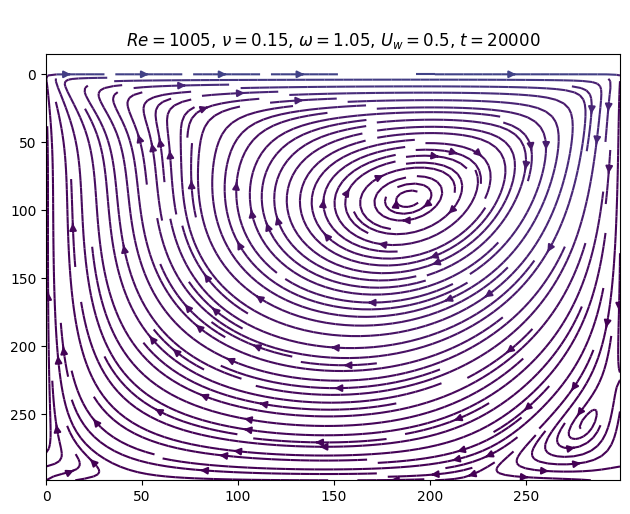

In [41]:
fig, ax = plt.subplots()
x = np.arange(L)
y = np.arange(L)
u = velocity_field[1]
v = velocity_field[0]
norm = plt.Normalize(0, wall_velocity)
ax.streamplot(x, y, u, v, color=np.sqrt(u**2 + v**2) if u.sum() and v.sum() else None, norm=norm, density=2.0)
fig.tight_layout()
ax.invert_yaxis()
plt.title(f"\n$Re={round(Re)}$, $\\nu={viscosity:.2f}$, $\omega={omega:.2f}$, $U_w={wall_velocity}$, $t={time_steps}$")
plt.show()